In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import random
from tensorflow import keras
from pathlib import Path
from gaussian_blur import apply_gaussian_blur
import json
print(tf.__version__)

2.19.0


In [2]:
home_dir=Path.home()
data_dir=f'{home_dir}/icon_classifier/screenshots_big'
model_save_path = f'{home_dir}/icon_classifier/saved_model.keras'
model_save_dir = f'{home_dir}/icon_classifier/tf_savedmodel'
test_dir= f'{home_dir}/icon_classifier/test'

img_height=48
img_width=48
batch_size=32

print(data_dir)

/Users/sam/icon_classifier/screenshots_big


In [3]:
def save_label_mapping(label_to_index, index_to_label, file_path='label_mapping.json'):
    """保存标签映射到文件"""
    mapping = {
        'label_to_index': label_to_index,
        'index_to_label': index_to_label
    }
    with open(file_path, 'w') as f:
        json.dump(mapping, f)

def load_label_mapping(file_path='label_mapping.json'):
    """从文件加载标签映射"""
    if not os.path.exists(file_path):
        print(f"文件不存在: {file_path}")
        return None, None
    print(f"加载标签映射: {file_path}")
    with open(file_path, 'r') as f:
        mapping = json.load(f)
    label_to_index = mapping['label_to_index'].items()
    index_to_label = mapping['index_to_label'].items()
    return {label : int(index) for label, index in label_to_index}, {int(index):label for index, label in index_to_label}
   

In [4]:
#从具有相同标签名的图片中 分出1000个放入测试集 用于评估模型效果
image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.png')]

filename = [os.path.splitext(os.path.basename(p))[0] for p in image_paths] 
labels = [label.split('_',maxsplit=1)[1].replace('-','_').lower() for label in filename]

unique_label = set()

train_path_label = []
validate_path_label = []



for i in range(len(labels)):
    path = image_paths[i]
    label = labels[i]
    if label not in unique_label:
        train_path_label.append((path,label))
        unique_label.add(label)
    else:
       validate_path_label.append((path,label)) 



random.shuffle(validate_path_label)
valid_1000 = validate_path_label[:1000]
train_path_label.extend(validate_path_label[1000:]) #剩下的放回训练集 



print(f'path {len(train_path_label)} label {len(unique_label)} train {len(valid_1000)}')





path 18045 label 5361 train 1000


In [5]:

# 尝试加载已有的标签映射
label_to_index, index_to_label = load_label_mapping()

# 如果没有保存的映射，创建新的映射并保存
if label_to_index is None:
    label_names = unique_label
    label_to_index = {name: idx for idx, name in enumerate(sorted(label_names))}
    index_to_label = {idx: label for label, idx in label_to_index.items()}
    # 保存映射
    save_label_mapping(label_to_index, index_to_label)


label_encoded = [label_to_index[label] for _, label in train_path_label]
print(f"class num {len(label_to_index)}")
print(label_encoded[:10])


加载标签映射: label_mapping.json
class num 5361
[3652, 3705, 11, 3734, 3979, 4115, 3207, 1669, 4216, 243]


In [6]:
#png是四通道的 
def rgba_to_rgb(rgba, background=(255, 255, 255)):
    """
    将RGBA转换为RGB，使用指定背景色混合透明区域
    
    参数:
    rgba: RGBA张量 (uint8, 形状 [H, W, 4])
    background: 背景颜色 (R, G, B) 元组 (0-255)
    
    返回:
    RGB张量 (uint8, 形状 [H, W, 3])
    """
    # 分离通道
    rgb = rgba[..., :3]
    alpha = rgba[..., 3:]
    
    # 转换为float32进行混合计算
    rgb = tf.cast(rgb, tf.float32)
    alpha = tf.cast(alpha, tf.float32) / 255.0  # 归一化到[0,1]
    
    # 创建背景张量
    bg = tf.ones_like(rgb) * tf.constant(background, dtype=tf.float32)
    
    # 混合公式: 前景 * alpha + 背景 * (1 - alpha)
    blended = rgb * alpha + bg * (1.0 - alpha)
    
    # 转换回uint8
    return tf.cast(blended, tf.uint8)

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)#white
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_and_preprocess_image_threshold(path, label, reversed):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 

    image = tf.cast(image, tf.float32)
    #高斯模糊 
    image = apply_gaussian_blur(image, kernel_size=3, sigma=0.5)
    #二值化
    max = tf.reduce_max(image)
    min = tf.reduce_min(image)
    threshold = (max + min) / 2;
    if reversed:
        image = tf.where(image > threshold, 0, 1)
    else:
        image = tf.where(image > threshold, 1, 0)
    
    #image = tf.cast(image, tf.float32)
    image = tf.squeeze(image)
    return image, label 


In [7]:
train_paths = [path for path, _ in  train_path_label]


print(len(train_paths), len(label_encoded))

path_ds_1 = tf.data.Dataset.from_tensor_slices((train_paths, label_encoded, [True]*len(train_paths)))
path_ds_2 = tf.data.Dataset.from_tensor_slices((train_paths, label_encoded, [False]*len(train_paths)))
image_label_ds_1 = path_ds_1.map(load_and_preprocess_image_threshold)
image_label_ds_2 = path_ds_2.map(load_and_preprocess_image_threshold)


image_ds = tf.data.Dataset.sample_from_datasets(
    [image_label_ds_1, image_label_ds_2],
    weights=[0.5, 0.5],
    stop_on_empty_dataset=False
)


dataset = image_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                                                    
images, labels_encoded = zip(*list(image_ds.as_numpy_iterator()))

images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

tf.squeeze(images_tensor)
print(images_tensor.shape)

18045 18045


2025-06-15 02:32:39.729807: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-15 02:32:39.729833: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-15 02:32:39.729838: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1749925959.729885 11381202 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749925959.729939 11381202 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-06-15 02:32:41.793966: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(36090, 48, 48)


In [8]:
#生成测试数据dataset
validate_paths = [path for path, _ in  valid_1000]
validate_label_encoded = [label_to_index[label] for _, label in valid_1000]

print(len(validate_paths), len(validate_label_encoded))

path_ds = tf.data.Dataset.from_tensor_slices((validate_paths, validate_label_encoded, [False]*len(validate_paths)))

validate_ds = path_ds.map(load_and_preprocess_image_threshold)

validate_set = validate_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                                                    

1000 1000


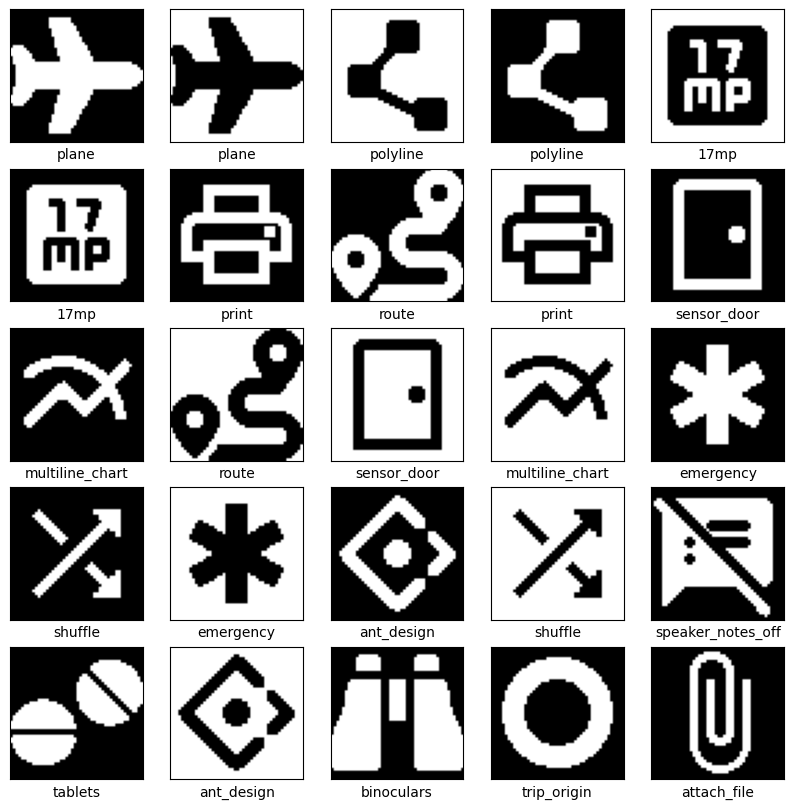

In [9]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_tensor[i].numpy().squeeze(), cmap=plt.cm.binary)
    plt.xlabel(index_to_label[labels_encoded[i]])
plt.show()  



In [10]:
num_classes=len(label_to_index)
model = tf.keras.Sequential([
    # 输入层
    tf.keras.layers.Input(shape=(img_height, img_width, 1)),
    
    # 第一个卷积块
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 第二个卷积块
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 第三个卷积块
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 全连接层
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 使用Adam优化器，添加学习率衰减
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             

 Total params: 5,400,273 (20.60 MB)

 Trainable params: 5,398,353 (20.59 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, acc=0.95):
        super().__init__()
        self.acc = acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= self.acc:
            print(f"\n达到{self.acc*100:.2f}%准确率，停止训练。")
            self.model.stop_training = True


#训练达到90%准确率时停止
history = model.fit(dataset, validation_data=validate_set, 
                        epochs=30, callbacks=[MyThresholdCallback(acc=0.95)], 
                        steps_per_epoch=(len(train_paths)*2)//batch_size)

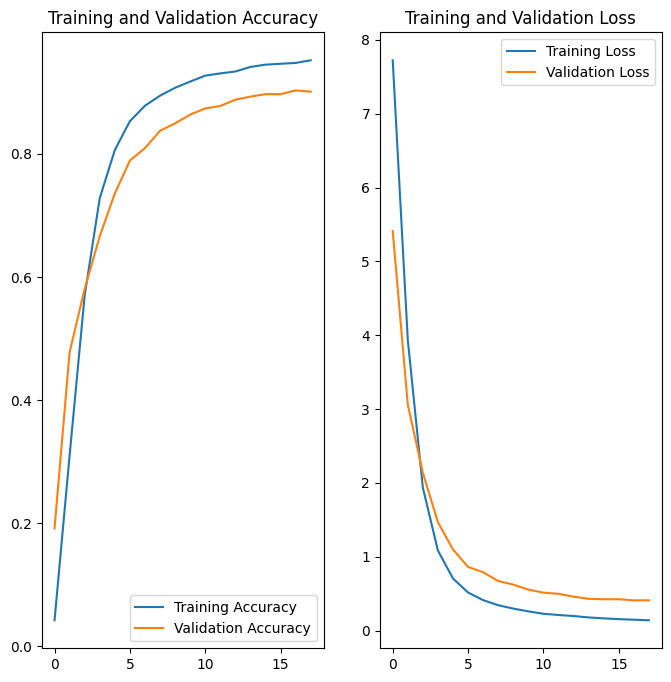

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(18)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
#记录模型
model.save("model_with_gaussian_blur.keras") #用于恢复keras

#saveModel格式用于转换到tensorflowjs
#tf.saved_model.save(model, model_save_dir)


In [19]:
# 加载模型
loaded_model = tf.keras.models.load_model("model_pre.keras", custom_objects={'GrayscaleLayer': GrayscaleLayer})

In [ ]:
loaded_model = tf.keras.models.load_model("model.keras")

NameError: name 'tf' is not defined

加载标签映射: label_mapping.json
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


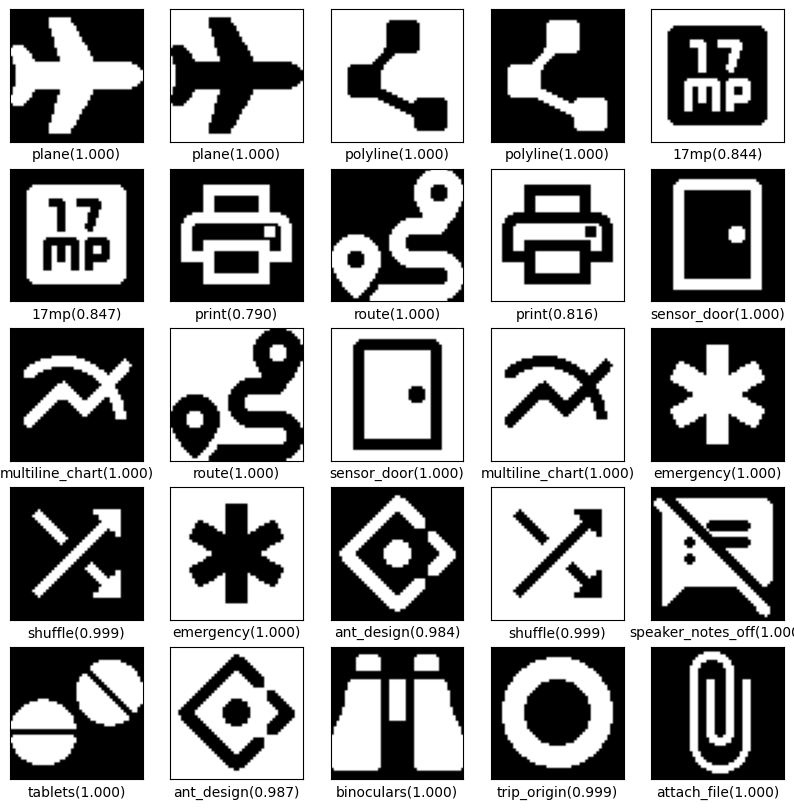

In [15]:
#在训练数据上验证
_, index_to_label = load_label_mapping()
predictions = model.predict(images_tensor)

plt.figure(figsize=(10,10))
for i in range(25):
    predicted_label = np.argmax(predictions[i])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_tensor[i], cmap=plt.cm.binary)
    label = f'{index_to_label[predicted_label]}({predictions[i][predicted_label]:.3f})'
    plt.xlabel(label)
plt.show() 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


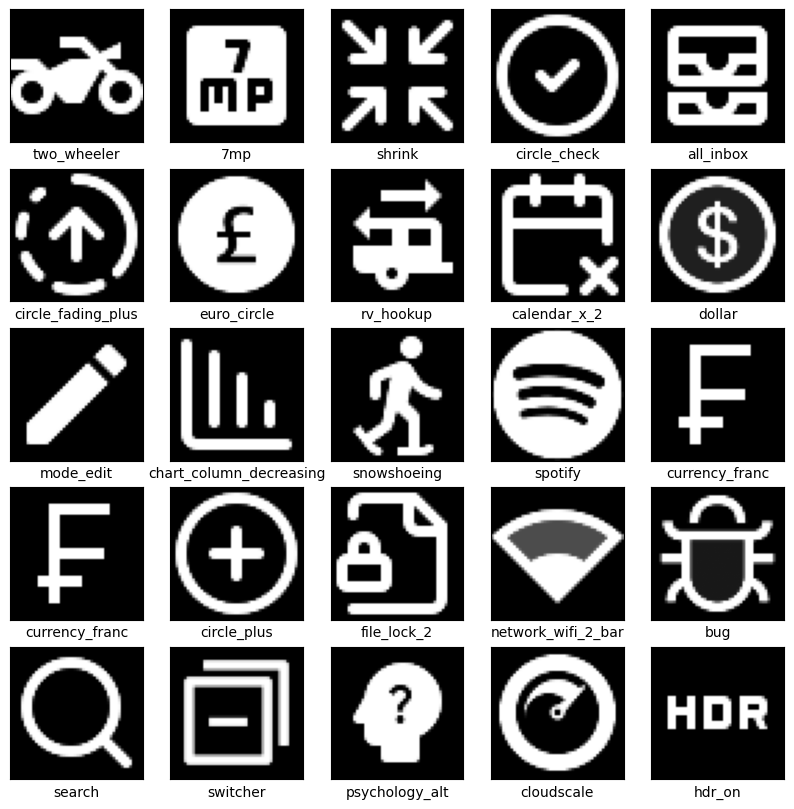

In [18]:
#在测试数据上验证
def load_and_preprocess_test_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 

    image = tf.cast(image, tf.float32)
    #高斯模糊 
    image = apply_gaussian_blur(image, kernel_size=3, sigma=0.5)
    #二值化
    max = tf.reduce_max(image)
    min = tf.reduce_min(image)
    threshold = (max + min) / 2;
    if reversed:
        image = tf.where(image > threshold, 0, 1)
    else:
        image = tf.where(image > threshold, 1, 0)
    
    #image = tf.cast(image, tf.float32)
    image = tf.squeeze(image)
    return image

test_paths = [path for path, label in valid_1000]
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_test_image)
test_image_ds = test_image_ds.batch(32)

predictions = model.predict(test_image_ds)

plt.figure(figsize=(10,10))
cnt = 25
for i in range(cnt):
    image = tf.io.read_file(test_paths[i])
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    s = np.argsort(predictions[i])
    first = s[-1]
    second = s[-2]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    label = f'{index_to_label[predicted_label]}'
    plt.xlabel(label)
plt.show()

In [1]:


#测试数据

test_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.png')]
#test_paths = ['/Users/rockyshan/icon_classifier/test/821_arrow_downward.png']
#test_paths = ['test/1_setting_test.png', 'test/2_settingtest2.png', 'test/333.png', 'test/search.png', 'test/download.png', '/Users/sam/icon_classifier/screenshots_big/489_cmplid.png']
#test_paths=['/Users/rockyshan/icon_tf/test/search.png', '/Users/rockyshan/icon_tf/test/config.png', '/Users/rockyshan/icon_tf/test/arrow.png','/Users/rockyshan/icon_tf/test/setting1.png']

print(test_paths)

def load_and_preprocess_test_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 

    image = tf.cast(image, tf.float32)
    #高斯模糊 
    image = apply_gaussian_blur(image, kernel_size=3, sigma=0.5)
    #二值化
    max = tf.reduce_max(image)
    min = tf.reduce_min(image)
    threshold = (max + min) / 2;

    image = tf.where(image > threshold, 1, 0)
    
    #image = tf.cast(image, tf.float32)
    image = tf.squeeze(image)
    return image



test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_test_image)
test_image_ds = test_image_ds.batch(32)

predictions = model.predict(test_image_ds)

plt.figure(figsize=(10,10))
cnt = len(test_paths) if len(test_paths) < 25 else 25
for i in range(cnt):
    image = tf.io.read_file(test_paths[i])
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    #print(image.shape, tf.reduce_max(image), tf.reduce_min(image))
    image = tf.image.resize(image, [img_height, img_width])
    
    #print(tf.reduce_max(image), tf.reduce_min(image))
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32)
    #高斯模糊 
    image = apply_gaussian_blur(image, kernel_size=3, sigma=0.5)
    #二值化
    max_ = tf.reduce_max(image)
    min_ = tf.reduce_min(image)
    threshold = (max_ + min_) / 2;

    image = tf.where(image > threshold, 1, 0)
    image = tf.squeeze(image)
  
  
    s = np.argsort(predictions[i])
    first = s[-1]
    second = s[-2]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap="gray")
    #plt.imshow(image, cmap="gray")
    #label = f'{index_to_label[first]}_{index_to_label[second]}'
    print(predicted_label)
    print(predictions[i][predicted_label])
    label=index_to_label[predicted_label]
    plt.xlabel(label)
plt.show()

NameError: name 'os' is not defined

In [54]:
def load_test_data(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

test_paths = [path for path, _ in valid_100]
test_label_encoded = [label_to_index[label] for _,label in valid_100]
test_path_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_label_encoded))
test_image_ds = test_path_ds.map(load_test_data)
test_image_ds = test_image_ds.batch(32)


test_loss, test_acc = model.evaluate(test_image_ds, verbose=2)

32/32 - 1s - 17ms/step - accuracy: 0.9210 - loss: 0.2614


/var/folders/fb/2pmq3wkx28g7xfh7g2ycwxrc0000gn/T/ipykernel_30627/2787041018.py:68: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/2pmq3wkx28g7xfh7g2ycwxrc0000gn/T/ipykernel_30627/2787041018.py:68: UserWarning: Glyph 36733 (\N{CJK UNIFIED IDEOGRAPH-8F7D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/2pmq3wkx28g7xfh7g2ycwxrc0000gn/T/ipykernel_30627/2787041018.py:68: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/2pmq3wkx28g7xfh7g2ycwxrc0000gn/T/ipykernel_30627/2787041018.py:68: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

/Users/sam/icon_classifier/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sam/icon_classifier/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36733 (\N{CJK UNIFIED IDEOGRAPH-8F7D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sam/icon_classifier/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sam/icon_classifier/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


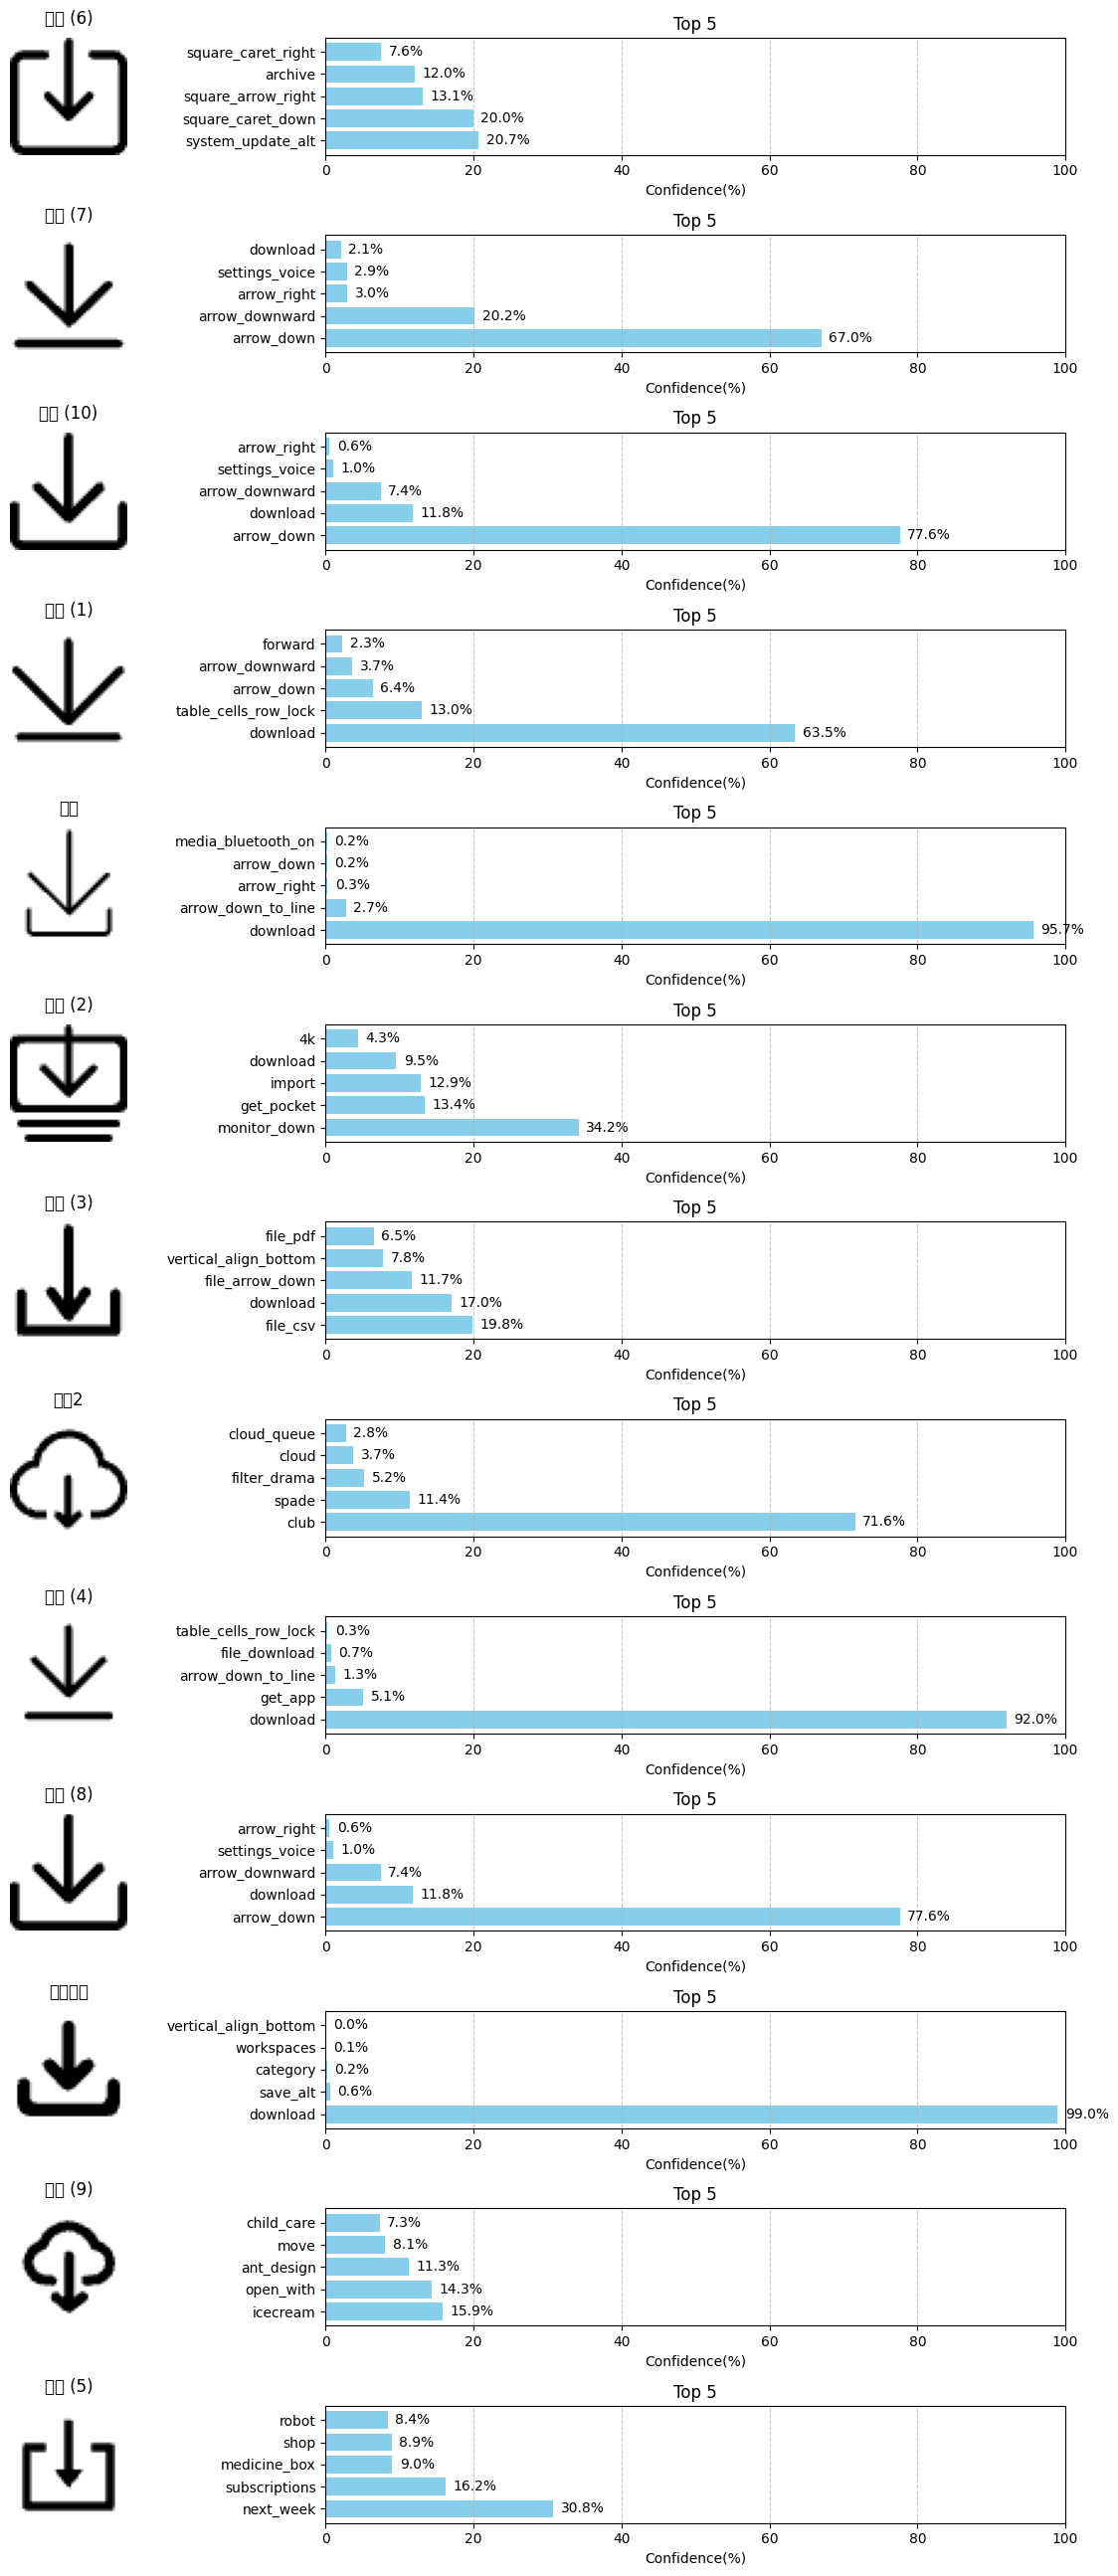

In [53]:
def plot_value_array(ax_bar, predictions_array):
    # 清除之前的图形
    ax_bar.clear()
    
    # 获取前5个最高预测值
    sorted_indices = np.argsort(predictions_array)
    top5_indices = sorted_indices[-5:][::-1]  # 反转顺序，从高到低
    
    # 准备数据
    values = predictions_array[top5_indices] * 100  # 转换为百分比
    labels = [index_to_label[i] for i in top5_indices]
    
    # 设置柱状图
    bars = ax_bar.barh(labels, values, color='skyblue')
    
    # 设置坐标轴
    ax_bar.set_xlim(0, 100)  # 设置x轴范围为0-100
    ax_bar.set_xticks(np.arange(0, 101, 20))  # 设置x轴刻度
    ax_bar.set_xlabel('Confidence(%)')
    
    # 在柱状图上添加数值标签
    for bar in bars:
        width = bar.get_width()
        ax_bar.text(width + 1, bar.get_y() + bar.get_height()/2,
                   f'{width:.1f}%',
                   ha='left', va='center')
    
    # 设置网格
    ax_bar.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # 移除y轴刻度
    #ax_bar.set_yticks([])
    
    # 设置标题
    ax_bar.set_title('Top 5')
  
  
  


plt.figure(figsize=(10,10))

num_rows = len(test_paths)
#num_rows = 2
fig, axes = plt.subplots(num_rows, 2, 
                         figsize=(12, 2 * num_rows),
                         gridspec_kw={'width_ratios': [1, 3]})  # 主图:柱状图 = 1:3

# 遍历每一行
for row in range(num_rows):
    # --- 绘制主图（左侧）---
    ax_img = axes[row, 0] 
    image = tf.io.read_file(test_paths[row])
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [48, 48])
    image = tf.image.rgb_to_grayscale(image) 
    ax_img.imshow(image, cmap="gray")
    ax_img.set_title(f"{os.path.splitext(os.path.basename(test_paths[row]))[0].split('_')[0]}", pad=10)
    ax_img.axis('off')  # 隐藏坐标轴

    # --- 绘制柱状图（右侧）---
    ax_bar = axes[row, 1] 
    plot_value_array(ax_bar, predictions[row])
    #ax_bar.axis('off')  # 隐藏坐标轴

# 调整布局
plt.tight_layout()
plt.show()

In [29]:
index_to_label[392]
#label_to_index['arrow_down']

'assignment_returned'

In [19]:
images_tensor[0]

<tf.Tensor: shape=(48, 48, 1), dtype=float32, numpy=
array([[[0.99990004],
        [0.99990004],
        [0.99990004],
        ...,
        [0.99990004],
        [0.99990004],
        [0.99990004]],

       [[0.99990004],
        [0.99990004],
        [0.99990004],
        ...,
        [0.99990004],
        [0.99990004],
        [0.99990004]],

       [[0.99990004],
        [0.99990004],
        [0.99990004],
        ...,
        [0.99990004],
        [0.99990004],
        [0.99990004]],

       ...,

       [[0.99990004],
        [0.99990004],
        [0.99990004],
        ...,
        [0.99990004],
        [0.99990004],
        [0.99990004]],

       [[0.99990004],
        [0.99990004],
        [0.99990004],
        ...,
        [0.99990004],
        [0.99990004],
        [0.99990004]],

       [[0.99990004],
        [0.99990004],
        [0.99990004],
        ...,
        [0.99990004],
        [0.99990004],
        [0.99990004]]], dtype=float32)>